<!-- dom:TITLE: Week 5 February 1-5: Importance Sampling, Fokker-Planck and Langevin equations -->
# Week 5 February 1-5: Importance Sampling, Fokker-Planck and Langevin equations
<!-- dom:AUTHOR: Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no at Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway & Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA -->
<!-- Author: -->  
**Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no**, Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA

Date: **Dec 14, 2020**

Copyright 1999-2020, Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no. Released under CC Attribution-NonCommercial 4.0 license




## Overview of week 5, February 1-5
**Topics.**

* Importance Sampling

* Fokker-Planck and Langevin equations



**Teaching Material, videos and written material.**

* Overview video

* Lecture notes and reading assignments

* Recommended background literature






## Importance sampling

The above way of performing a Monte Carlo calculation is not the most efficient one. 
We need to replace the brute force Metropolis algorithm with a walk in
coordinate space biased by the trial wave function.  This approach is
based on the Fokker-Planck equation and the Langevin equation for
generating a trajectory in coordinate space.  The link between the
Fokker-Planck equation and the Langevin equations are explained, only
partly, in the slides below.  An excellent reference on topics like
Brownian motion, Markov chains, the Fokker-Planck equation and the
Langevin equation is the text by [Van Kampen](http://www.elsevier.com/books/stochastic-processes-in-physics-and-chemistry/van-kampen/978-0-444-52965-7)
Here we will focus first on the implementation part first.

For a diffusion process characterized by a time-dependent probability density $P(x,t)$ in one dimension the Fokker-Planck
equation reads (for one particle /walker)

$$
\frac{\partial P}{\partial t} = D\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x} -F\right)P(x,t),
$$

where $F$ is a drift term and $D$ is the diffusion coefficient. 


The new positions in coordinate space are given as the solutions of the Langevin equation using Euler's method, namely,
we go from the Langevin equation

$$
\frac{\partial x(t)}{\partial t} = DF(x(t)) +\eta,
$$

with $\eta$ a random variable,
yielding a new position

$$
y = x+DF(x)\Delta t +\xi\sqrt{\Delta t},
$$

where $\xi$ is gaussian random variable and $\Delta t$ is a chosen time step. 
The quantity $D$ is, in atomic units, equal to $1/2$ and comes from the factor $1/2$ in the kinetic energy operator. Note that $\Delta t$ is to be viewed as a parameter. Values of $\Delta t \in [0.001,0.01]$ yield in general rather stable values of the ground state energy.  

The process of isotropic diffusion characterized by a time-dependent probability density $P(\mathbf{x},t)$ obeys (as an approximation) the so-called Fokker-Planck equation

$$
\frac{\partial P}{\partial t} = \sum_i D\frac{\partial }{\partial \mathbf{x_i}}\left(\frac{\partial }{\partial \mathbf{x_i}} -\mathbf{F_i}\right)P(\mathbf{x},t),
$$

where $\mathbf{F_i}$ is the $i^{th}$ component of the drift term (drift velocity) caused by an external potential, and $D$ is the diffusion coefficient. The convergence to a stationary probability density can be obtained by setting the left hand side to zero. The resulting equation will be satisfied if and only if all the terms of the sum are equal zero,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial}{\partial {\mathbf{x_i}}}\mathbf{F_i} + \mathbf{F_i}\frac{\partial}{\partial {\mathbf{x_i}}}P.
$$

The drift vector should be of the form $\mathbf{F} = g(\mathbf{x}) \frac{\partial P}{\partial \mathbf{x}}$. Then,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial g}{\partial P}\left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2 + P g \frac{\partial ^2 P}{\partial {\mathbf{x}_i^2}}  + g \left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2.
$$

The condition of stationary density means that the left hand side equals zero. In other words, the terms containing first and second derivatives have to cancel each other. It is possible only if $g = \frac{1}{P}$, which yields

$$
\mathbf{F} = 2\frac{1}{\Psi_T}\nabla\Psi_T,
$$

which is known as the so-called *quantum force*. This term is responsible for pushing the walker towards regions of configuration space where the trial wave function is large, increasing the efficiency of the simulation in contrast to the Metropolis algorithm where the walker has the same probability of moving in every direction.

The Fokker-Planck equation yields a (the solution to the equation) transition probability given by the Green's function

$$
G(y,x,\Delta t) = \frac{1}{(4\pi D\Delta t)^{3N/2}} \exp{\left(-(y-x-D\Delta t F(x))^2/4D\Delta t\right)}
$$

which in turn means that our brute force Metropolis algorithm

$$
A(y,x) = \mathrm{min}(1,q(y,x))),
$$

with $q(y,x) = |\Psi_T(y)|^2/|\Psi_T(x)|^2$ is now replaced by the [Metropolis-Hastings algorithm](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114). See also  [Hasting's original article](http://biomet.oxfordjournals.org/content/57/1/97.abstract),

$$
q(y,x) = \frac{G(x,y,\Delta t)|\Psi_T(y)|^2}{G(y,x,\Delta t)|\Psi_T(x)|^2}
$$

### Code example for the interacting case with importance sampling

We are now ready to implement importance sampling. This is done here for the two-electron case with the Coulomb interaction, as in the previous example. We have two variational parameters $\alpha$ and $\beta$. After the set up of files

In [1]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCQdotImportance"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCQdotImportance.dat"),'w')

we move on to the set up of the trial wave function, the analytical expression for the local energy and the analytical expression for the quantum force.

In [2]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# No energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit,njit


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce

The Monte Carlo sampling includes now the Metropolis-Hastings algorithm, with the additional complication of having to evaluate the **quantum force** and the Green's function which is the solution of the Fokker-Planck equation.

In [3]:
# The Monte Carlo sampling with the Metropolis algo
# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit()
def MonteCarloSampling():

    NumberMCcycles= 100000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    # start variational parameter  loops, two parameters here
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
            wfold = WaveFunction(PositionOld,alpha,beta)
            QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                           QuantumForceOld[i,j]*TimeStep*D
                    wfnew = WaveFunction(PositionNew,alpha,beta)
                    QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
                    GreensFunction = 0.0
                    for j in range(Dimension):
                        GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
                    GreensFunction = exp(GreensFunction)
                    ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
                    #Metropolis-Hastings test to see whether we accept the move
                    if random() <= ProbabilityRatio:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                           QuantumForceOld[i,j] = QuantumForceNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            # We calculate mean, variance and error (no blocking applied)
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, AlphaValues, BetaValues

The main part here contains the setup of the variational parameters, the energies and the variance.

<ipython-input-3-17bba4d2d0a9>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "MonteCarloSampling" failed type inference due to: Untyped global name 'WaveFunction': Cannot determine Numba type of <class 'function'>

File "<ipython-input-3-17bba4d2d0a9>", line 35:
def MonteCarloSampling():
    <source elided>
                    PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
            wfold = WaveFunction(PositionOld,alpha,beta)
            ^

  @jit()
<ipython-input-3-17bba4d2d0a9>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "MonteCarloSampling" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-3-17bba4d2d0a9>", line 22:
def MonteCarloSampling():
    <source elided>
    alpha = 0.9
    for ia in range(MaxVariations):
    ^

  @jit()
/Users/MortenImac/anaconda3/lib/python3.6/site-pack

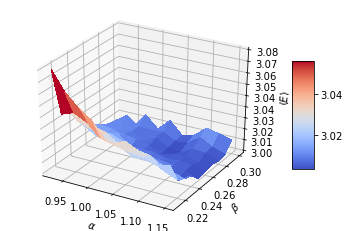

In [4]:
#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()
# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotImportance")
plt.show()

## Technical aspects, improvements and how to define the cost function

The above procedure is also not the smartest one. Looping over all
variational parameters becomes expensive and we see from the previous
plot that the surface is not very smooth, indicating that we need many more
Monte Carlo cycles in order to reliably define an energy minimum. 

What we can do however is to perform some preliminary calculations
with selected variational parameters (normally with less Monte Carlo
cycles than those used in a full production calculation). For every
step we evaluate the derivatives of the energy as functions of the
variational parameters. When the derivatives disappear we have
hopefully reached the global minimum.

At this point we have the optimal variational parameters and can start
our large-scale production run.  To find the optimal parameters
entails the computation of the gradients of the energy and
optimization algorithms like various **gradient descent** methods.
This is an art by itself and is discussed for example in [our lectures on optimization methods](http://compphysics.github.io/ComputationalPhysics2/doc/pub/cg/html/cg.html). We refer the reader to these notes for more details.

This part allows us also to link with the true working horse of every
Machine Learning algorithm, namely the optimization part. This
normally involves one of the stochastic gradient descent algorithms
discussed in the above lecture notes. We will come back to these topics in the second notebook. 

In order to apply these optmization algortihms we anticipate partly what is to come in notebook 2 on
Boltzmann machines. Our cost (or loss) function is here given by the
expectation value of the energy as function of the variational
parameters.

To find the derivatives of the local energy expectation value as
function of the variational parameters, we can use the chain rule and
the hermiticity of the Hamiltonian.

Let us define

$$
\bar{E}_{\alpha_i}=\frac{d\langle  E_L\rangle}{d\alpha_i}.
$$

as the derivative of the energy with respect to the variational parameter $\alpha_i$
We define also the derivative of the trial function (skipping the subindex $T$) as

$$
\bar{\Psi}_{i}=\frac{d\Psi}{d\alpha_i}.
$$

The elements of the gradient of the local energy are then (using the
chain rule and the hermiticity of the Hamiltonian)

$$
\bar{E}_{i}=
2\left( \langle \frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle -\langle
\frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L \rangle\right).
$$

From a computational point of view it means that we need to compute
the expectation values of

$$
\langle
\frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle,
$$

and

$$
\langle
\frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L\rangle
$$

These integrals are evaluted using MC intergration (with all its possible
error sources).  We can then use methods like stochastic gradient or
other minimization methods to find the optimal variational parameters



As an alternative to the energy as cost function, we could use the variance as the cost function.
As discussed earlier, if we have the exact wave function, the variance is exactly equal to zero.
Suppose the trial function (our model) is the exact wave function. 

The variance is defined as

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2.
$$

Some practitioners perform Monte Carlo calculations by minimizing both the energy and the variance.

In order to minimize the variance we need the derivatives of

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2,
$$

with respect to the variational parameters. The derivatives of the variance can then be used to defined the
so-called Hessian matrix, which in turn allows us to use minimization methods like Newton's method or 
standard gradient methods. 

This leads to however a more complicated expression, with obvious errors when evaluating many more integrals by Monte Carlo integration. It is normally less used, see however [Filippi and Umrigar](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.94.150201). The expression becomes complicated

$$
\bar{E}_{ij} = 2\left[ \langle (\frac{\bar{\Psi}_{ij}}{\Psi}+\frac{\bar{\Psi}_{j}}{\Psi}\frac{\bar{\Psi}_{i}}{\Psi})(E_L-\langle E\rangle)\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\bar{E}_j-\langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\bar{E}_i\right] +\langle \frac{\bar{\Psi}_{i}}{\Psi}E_L{_j}\rangle +\langle \frac{\bar{\Psi}_{j}}{\Psi}E_L{_i}\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L{_j}\rangle \langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\langle E_L{_i}\rangle.
$$

Evaluating the cost function means having to evaluate the above second derivative of the energy. 

Before we proceed with code examples, let us look at some simple examples, here the one-particle harmonic oscillator in one dimension. This serves as a very useful check when developing a code. The first code discussed is the two-dimensional non-interacting harmonic oscillator. 

### Simple example

Let us illustrate what is needed in our calculations using a simple
example, the harmonic oscillator in one dimension.  For the harmonic
oscillator in one-dimension we have a trial wave function and
probability

$$
\psi_T(x) = e^{-\alpha^2 x^2} \qquad P_T(x)dx = \frac{e^{-2\alpha^2 x^2}dx}{\int dx e^{-2\alpha^2 x^2}}
$$

with $\alpha$ being the variational parameter. 
We obtain then the following local energy

$$
E_L[\alpha] = \alpha^2+x^2\left(\frac{1}{2}-2\alpha^2\right),
$$

which results in the expectation value for the local energy

$$
\langle  E_L[\alpha]\rangle = \frac{1}{2}\alpha^2+\frac{1}{8\alpha^2}
$$

The derivative of the energy with respect to $\alpha$ gives

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = \alpha-\frac{1}{4\alpha^3}
$$

and a second derivative which is always positive (meaning that we find a minimum)

$$
\frac{d^2\langle  E_L[\alpha]\rangle}{d\alpha^2} = 1+\frac{3}{4\alpha^4}
$$

The condition

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = 0,
$$

gives the optimal $\alpha=1/\sqrt{2}$, as expected.

We can also minimize the variance. In our simple model the variance is

$$
\sigma^2[\alpha] = \frac{1}{2}\alpha^4-\frac{1}{4}+\frac{1}{32\alpha^4},
$$

with first derivative

$$
\frac{d \sigma^2[\alpha]}{d\alpha} = 2\alpha^3-\frac{1}{8\alpha^5}
$$

and a second derivative which is always positive (as expected for a convex function)

$$
\frac{d^2\sigma^2[\alpha]}{d\alpha^2} = 6\alpha^2+\frac{5}{8\alpha^6}
$$

In general we end up computing the expectation value of the energy in
terms of some parameters $\alpha_0,\alpha_1,\dots,\alpha_n$ and we
search for a minimum in this multi-variable parameter space.  This
leads to an energy minimization problem *where we need the derivative
of the energy as a function of the variational parameters*.

In the above example this was easy and we were able to find the
expression for the derivative by simple derivations.  However, in our
actual calculations the energy is represented by a multi-dimensional
integral with several variational parameters.